In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

In [9]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

# Train simple baseline (Linear Regression models)

metric: [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

In [2]:
# load data
df = pd.read_csv('ephemerides.csv', index_col=0)

In [8]:
df.head()

,time,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,2014-01-01T00:00:00.000,0,-174888.951965,-265568.785988,217841.949902,-0.007575,0.665873,0.805676,-174482.150004,-265867.392143,218370.330515,-0.006604,0.665740,0.807812
1,2014-01-01T00:00:00.000,1,-3416.366748,-81565.608624,168905.075240,-0.935510,1.390621,0.652620,-2778.952278,-83937.757266,169915.555887,-0.936387,1.392969,0.652633
2,2014-01-01T00:00:00.000,2,153335.857299,-173831.884831,36608.049261,-0.639141,-0.810197,-1.170094,154067.064465,-175005.173107,36769.795485,-0.637430,-0.806600,-1.166212
3,2014-01-01T00:00:00.000,3,42217.785595,132119.619756,35763.807577,2.057849,-0.563044,-0.349200,42048.279640,137356.495120,36137.452195,2.057364,-0.562728,-0.349683
4,2014-01-01T00:00:00.000,4,125679.059962,-48416.909578,69271.781964,0.077410,1.763949,1.092452,123971.071799,-47676.640634,70226.932742,0.069301,1.765183,1.095993


(array([ 226.,  715., 2577., 4069., 3454., 3080., 3096., 3136., 1260.,
         287.]), array([-604531.7517331 , -485214.90297885, -365898.0542246 ,
        -246581.20547036, -127264.35671611,   -7947.50796187,
         111369.34079238,  230686.18954663,  350003.03830087,
         469319.88705512,  588636.73580936]), <a list of 10 Patch objects>)

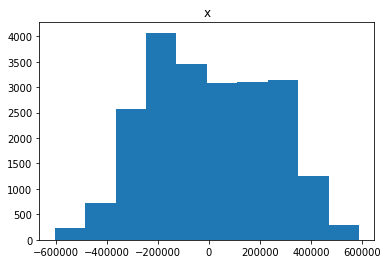

In [15]:
plt.title('x')
plt.hist(df.x)

(array([ 106.,  705., 2548., 3756., 3735., 3710., 2960., 2421., 1788.,
         171.]), array([-631260.89329227, -514669.77028907, -398078.64728587,
        -281487.52428267, -164896.40127947,  -48305.27827627,
          68285.84472693,  184876.96773013,  301468.09073333,
         418059.21373653,  534650.33673973]), <a list of 10 Patch objects>)

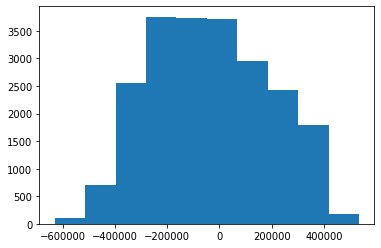

In [12]:
plt.hist(df.y)

(array([  11.,  229., 1504., 5130., 4194., 5087., 4744.,  881.,  102.,
          18.]),
 array([-2.51146501, -1.99479634, -1.47812768, -0.96145901, -0.44479034,
         0.07187832,  0.58854699,  1.10521565,  1.62188432,  2.13855298,
         2.65522165]),
 <a list of 10 Patch objects>)

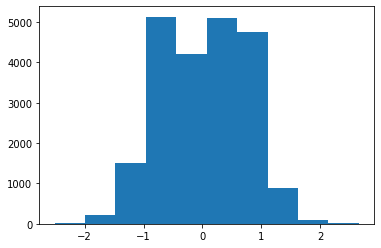

In [13]:
plt.hist(df.Vx)

(array([  38.,  274.,  920., 3499., 5020., 5055., 5064., 1626.,  317.,
          87.]),
 array([-2.50041344, -2.02991268, -1.55941192, -1.08891116, -0.6184104 ,
        -0.14790964,  0.32259112,  0.79309189,  1.26359265,  1.73409341,
         2.20459417]),
 <a list of 10 Patch objects>)

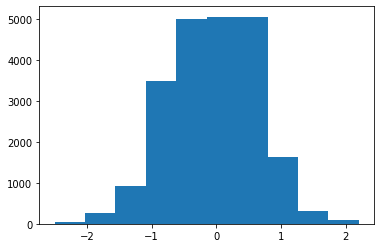

In [14]:
plt.hist(df.Vy)

In [3]:
# target variables columns 
target_cols = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
# features columns 
feature_cols = [c for c in df.columns if c not in target_cols and c != 'time']
# number of rows for training, validation and prediction
n_train = df.shape[0] - np.isnan(df[target_cols[0]]).sum()
n_val = int(0.2 * n_train)
n_train = n_train - n_val
n_test = df.shape[0] - n_train - n_val

print(f"n_train: {n_train}\nn_val: {n_val}\nn_test: {n_test}")
assert n_train + n_val + n_test == df.shape[0]

# train, validation, test arrays
X_train = df[feature_cols].values[:n_train]
y_train = dict(zip(target_cols, [df[l].values[:n_train] for l in target_cols]))
X_val = df[feature_cols].values[n_train:n_train+n_val]
y_val = dict(zip(target_cols, [df[l].values[n_train:n_train+n_val] for l in target_cols]))
X_test = df[feature_cols].values[n_train+n_val:]

assert X_train.shape[0] == y_train[target_cols[0]].shape[0] == n_train
assert X_val.shape[0] == y_val[target_cols[0]].shape[0] == n_val
assert X_test.shape[0] == n_test

n_train: 17520
n_val: 4380
n_test: 9400


In [4]:
# dictionary: {variable: LR predictions}
y_test = {}

_mape_train_list = []
_mape_val_list = []
for k, v in y_train.items():
    model = LinearRegression().fit(X_train, v)
    mape_train = np.mean(np.abs((model.predict(X_train) - v) / v)) * 100
    _mape_train_list.append(mape_train)
    mape_val = np.mean(np.abs((model.predict(X_val) - y_val[k]) / y_val[k])) * 100
    _mape_val_list.append(mape_val)
    model = LinearRegression().fit(
        np.vstack([X_train, X_val]), np.hstack([v, y_val[k]]))
    y_test[k] = model.predict(X_test)
    print(k)
    print("MAPE train: ", mape_train)
    print("MAPE val: ", mape_val, "\n")

print("------")
print("mean MAPE train: ", np.mean(_mape_train_list))
print("mean MAPE val: ", np.mean(_mape_val_list))

x
MAPE train:  2.7567727600464633
MAPE val:  9.020985138294844 

y
MAPE train:  1.9390680432773442
MAPE val:  0.9039356458499594 

z
MAPE train:  3.009183046955286
MAPE val:  0.9205662275527899 

Vx
MAPE train:  1.418021503785793
MAPE val:  2.366280615350265 

Vy
MAPE train:  1.7871230286264799
MAPE val:  1.6511369096904476 

Vz
MAPE train:  1.9287174769356301
MAPE val:  1.875870853003923 

------
mean MAPE train:  2.1398143099378326
mean MAPE val:  2.7897958982903717


In [5]:
# predictions
predictions = pd.DataFrame(y_test, index=df.index[-n_test:])
predictions.to_csv('predictions.csv')

In [8]:
!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/96/84/4e2cae6247f397f83d8adc5c2a2a0c5d7d790a14a4c7400ff6574586f589/xgboost-0.90.tar.gz
    ERROR: Command errored out with exit status 1:
     command: /Users/denissurin/opt/anaconda3/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/gg/3sw3zdf913xdgjyktqrthqrr0000gn/T/pip-install-j5sqdrb3/xgboost/setup.py'"'"'; __file__='"'"'/private/var/folders/gg/3sw3zdf913xdgjyktqrthqrr0000gn/T/pip-install-j5sqdrb3/xgboost/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base pip-egg-info
         cwd: /private/var/folders/gg/3sw3zdf913xdgjyktqrthqrr0000gn/T/pip-install-j5sqdrb3/xgboost/
    Complete output (29 lines):
    ++ pwd
    + oldpath=/private/var/folders/gg/3sw3zdf913xdgjyktqrthqrr0000gn/T/pip-install-j5sqdrb3/xgboost
    + cd ./xgboost/
    + echo darwin19


## Разлинчные стандарнтые sklearn models

In [9]:
import xgboost
# dictionary: {variable: LR predictions}
y_test = {}
_mape_train_list = []
_mape_val_list = []
for k, v in y_train.items():
    model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 
    model.fit(X_train, v)
    mape_train = np.mean(np.abs((model.predict(X_train) - v) / v)) * 100
    _mape_train_list.append(mape_train)
    mape_val = np.mean(np.abs((model.predict(X_val) - y_val[k]) / y_val[k])) * 100
    _mape_val_list.append(mape_val)
    model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 
    model.fit(
        np.vstack([X_train, X_val]), np.hstack([v, y_val[k]]))
    y_test[k] = model.predict(X_test)
    print(k)
    print("MAPE train: ", mape_train)
    print("MAPE val: ", mape_val, "\n")

print("------")
print("mean MAPE train: ", np.mean(_mape_train_list))
print("mean MAPE val: ", np.mean(_mape_val_list))

[17:09:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
x
MAPE train:  7.11423715863216
MAPE val:  506.4683157622353 

[17:13:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:14:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
y
MAPE train:  2.705351351015066
MAPE val:  10.844870050897397 

[17:15:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:17:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
z
MAPE train:  22.904018272862427
MAPE val:  12.673998960792806 

[17:18:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarede

In [10]:
from sklearn.linear_model import Ridge
# dictionary: {variable: LR predictions}
y_test = {}
_mape_train_list = []
_mape_val_list = []
for k, v in y_train.items():
    model = Ridge() 
    model.fit(X_train, v)
    mape_train = np.mean(np.abs((model.predict(X_train) - v) / v)) * 100
    _mape_train_list.append(mape_train)
    mape_val = np.mean(np.abs((model.predict(X_val) - y_val[k]) / y_val[k])) * 100
    _mape_val_list.append(mape_val)
    model = Ridge() 
    model.fit(
        np.vstack([X_train, X_val]), np.hstack([v, y_val[k]]))
    y_test[k] = model.predict(X_test)
    print(k)
    print("MAPE train: ", mape_train)
    print("MAPE val: ", mape_val, "\n")

print("------")
print("mean MAPE train: ", np.mean(_mape_train_list))
print("mean MAPE val: ", np.mean(_mape_val_list))

x
MAPE train:  2.75678780541226
MAPE val:  9.021076463454996 

y
MAPE train:  1.9390674982749687
MAPE val:  0.9039355070723956 

z
MAPE train:  3.009195130695515
MAPE val:  0.9205662958426057 

Vx
MAPE train:  1.4216994722366327
MAPE val:  2.354210360009594 

Vy
MAPE train:  1.7817795275210626
MAPE val:  1.6531239475982922 

Vz
MAPE train:  1.8638209686286835
MAPE val:  1.82575992516081 

------
mean MAPE train:  2.128725067128187
mean MAPE val:  2.7797787498564492


In [4]:
import sklearn.ensemble

In [5]:
from sklearn.ensemble import RandomForestRegressor

In [6]:
# dictionary: {variable: LR predictions}
y_test = {}
_mape_train_list = []
_mape_val_list = []
for k, v in y_train.items():
    model = RandomForestRegressor() 
    model.fit(X_train, v)
    mape_train = np.mean(np.abs((model.predict(X_train) - v) / v)) * 100
    _mape_train_list.append(mape_train)
    mape_val = np.mean(np.abs((model.predict(X_val) - y_val[k]) / y_val[k])) * 100
    _mape_val_list.append(mape_val)
    model = RandomForestRegressor()
    model.fit(
        np.vstack([X_train, X_val]), np.hstack([v, y_val[k]]))
    y_test[k] = model.predict(X_test)
    print(k)
    print("MAPE train: ", mape_train)
    print("MAPE val: ", mape_val, "\n")

print("------")
print("mean MAPE train: ", np.mean(_mape_train_list))
print("mean MAPE val: ", np.mean(_mape_val_list))

x
MAPE train:  1.5907743058687336
MAPE val:  7.725942731809567 

y
MAPE train:  0.8894792498270203
MAPE val:  1.2873913366962995 

z
MAPE train:  1.2848195085291958
MAPE val:  1.2718547806864073 

Vx
MAPE train:  0.6180243663634727
MAPE val:  2.9637937358479363 

Vy
MAPE train:  0.7423788798146479
MAPE val:  2.3353795357499 

Vz
MAPE train:  0.8277630342425654
MAPE val:  2.2123394549124247 

------
mean MAPE train:  0.9922065574409392
mean MAPE val:  2.9661169292837557


In [ ]:
# dictionary: {variable: LR predictions}
y_test = {}
_mape_train_list = []
_mape_val_list = []
for k, v in y_train.items():
    model = RandomForestRegressor() 
    model.fit(X_train, v)
    mape_train = np.mean(np.abs((model.predict(X_train) - v) / v)) * 100
    _mape_train_list.append(mape_train)
    mape_val = np.mean(np.abs((model.predict(X_val) - y_val[k]) / y_val[k])) * 100
    _mape_val_list.append(mape_val)
    model = RandomForestRegressor()
    model.fit(
        np.vstack([X_train, X_val]), np.hstack([v, y_val[k]]))
    y_test[k] = model.predict(X_test)
    print(k)
    print("MAPE train: ", mape_train)
    print("MAPE val: ", mape_val, "\n")

print("------")
print("mean MAPE train: ", np.mean(_mape_train_list))
print("mean MAPE val: ", np.mean(_mape_val_list))